Creating a Custom Grid-World Environment

Defining the Grid

Defining States, Actions, and Rewards

Implementing Environment Dynamics

Training the DQN Agent in the Grid-World

Setting up the Training Loop

Implementing the Epsilon-Greedy Policy

Calculating the Loss

Performing the Optimization Step

Evaluating the Trained Policy in the Grid-World



In the classic CartPole, a cart moves along a track, balancing a pole. We’ll simplify this into a discrete grid:

Cart Position: Discretized into a fixed number of positions (e.g., 10 slots).

Pole Angle: Discretized into a small number of angle bins (e.g., 5 bins).

Velocity: Omitted for simplicity (or coarsely discretized if desired), as velocity adds complexity to a gridworld. 

Instead, we’ll model the dynamics implicitly through probabilistic transitions.

Actions: Move left (0) or move right (1), matching CartPole’s discrete action space.

State 

State: A tuple (cart_pos, pole_angle):

cart_pos: Integer from 0 to 9 (10 positions).

pole_angle: Integer from 0 to 4 (5 bins: -12° to 12°, centered around upright).

state_dim: Flattened into a one-hot encoded vector or raw integers, depending on how we feed it to the DQN. For simplicity, we’ll use a 2D integer array [cart_pos, pole_angle], so state_dim = 2.

Actions

action_dim = 2:

0: Move cart left.

1: Move cart right.

Dynamics


Cart Movement:

Left: cart_pos -= 1 (bounded at 0).

Right: cart_pos += 1 (bounded at 9).

Pole Dynamics: Without velocity, we’ll simulate pole tipping probabilistically:

If the cart moves left, the pole has a chance to tip right (angle increases).

If the cart moves right, the pole tips left (angle decreases).

If no action balances it, the pole may tip randomly due to “gravity.”

Transition probabilities (simplified):

70% chance the pole tips in the direction opposite to the cart’s movement.

20% chance it stays the same.

10% chance it tips randomly.

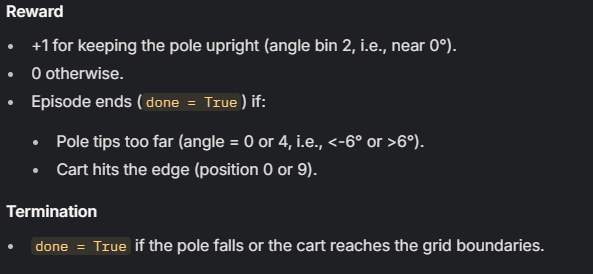

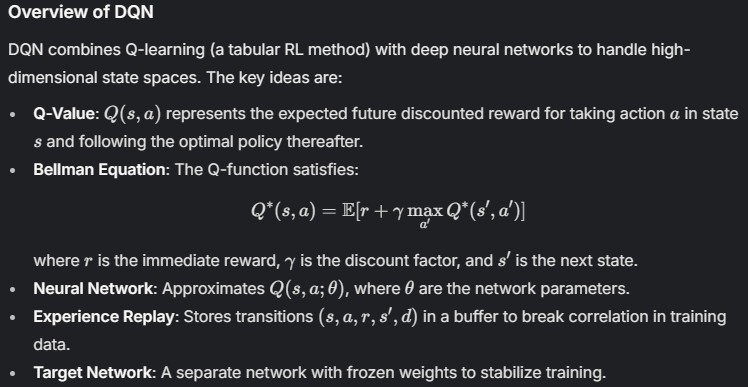

In [ ]:
# Grid Setup:
# grid_width = 10: Cart moves across 10 discrete positions.
# angle_bins = 5: Pole angle discretized into 5 bins (e.g., [-12°, -6°, 0°, 6°, 12°]).
# action_space = 2: Matches the DQN’s action_dim.
# state_dim = 2: State is [cart_pos, pole_angle].
# Reset: Called to set the initial state.
# Reset (reset)
# Initial State:
# Cart at position 5 (middle of the grid).
# Pole at angle bin 2 (upright, 0°).
# Return: A NumPy array [5, 2] as the starting state, compatible with DQNAgent’s torch.tensor conversion.
# Step (step)
# Action Handling:
# Action 0: Move left, bounded at 0.
# Action 1: Move right, bounded at 9.
# Pole Dynamics:
# Probabilistic tipping based on action:
# Left move: 70% chance to tip right, 20% stay, 10% tip left.
# Right move: 70% chance to tip left, 20% stay, 10% tip right.
# Uses np.random.random() to sample the outcome.
# Reward:
# +1 if pole is upright (bin 2).
# 0 otherwise.
# Done:
# True if pole tips to extremes (0 or 4) or cart hits edges (0 or 9).
# Return: (next_state, reward, done) as a tuple:
# next_state: [cart_pos, pole_angle] (float32 for DQN compatibility).
# reward: Float.
# done: Boolean.
# Render (render)
# Optional text visualization:
# Cart position shown as ‘C’ on a grid of underscores.
# Pole angle shown as ‘|’ among dashes.

In [5]:
import numpy as np

class GridCartPoleEnv:
    def __init__(self):
        self.grid_width = 10  # Cart positions: 0 to 9
        self.angle_bins = 5   # Angle bins: 0 to 4 (representing -12° to 12°)
        self.action_space = 2 # Actions: 0 (left), 1 (right)
        self.state_dim = 2    # State: [cart_pos, pole_angle]
        self.reset()

    def reset(self):
        # Start with cart in the middle and pole upright
        self.cart_pos = self.grid_width // 2  # Position 5
        self.pole_angle = 2                   # Upright (middle bin)
        return np.array([self.cart_pos, self.pole_angle], dtype=np.float32)

    def step(self, action):
        # Action: 0 (left), 1 (right)
        if action == 0:
            self.cart_pos = max(0, self.cart_pos - 1)
            tip_prob = [0.1, 0.2, 0.7]  # Tip left, stay, tip right
        else:
            self.cart_pos = min(self.grid_width - 1, self.cart_pos + 1)
            tip_prob = [0.7, 0.2, 0.1]  # Tip left, stay, tip right

        # Simulate pole tipping
        current_angle = self.pole_angle
        r = np.random.random()
        if r < tip_prob[0]:
            self.pole_angle = max(0, current_angle - 1)  # Tip left
        elif r < tip_prob[0] + tip_prob[1]:
            self.pole_angle = current_angle              # Stay
        else:
            self.pole_angle = min(self.angle_bins - 1, current_angle + 1)  # Tip right

        # Reward
        reward = 1.0 if self.pole_angle == 2 else 0.0

        # Done conditions
        done = (self.pole_angle == 0 or self.pole_angle == 4 or
                self.cart_pos == 0 or self.cart_pos == self.grid_width - 1)

        next_state = np.array([self.cart_pos, self.pole_angle], dtype=np.float32)
        return next_state, reward, done

    def render(self):
        # Simple text-based rendering
        grid = ['_'] * self.grid_width
        grid[self.cart_pos] = 'C'
        pole = ['-'] * self.angle_bins
        pole[self.pole_angle] = '|'
        print(' '.join(grid))
        print(' '.join(pole))

Grid Setup:

grid_width = 10: Cart moves across 10 discrete positions.

angle_bins = 5: Pole angle discretized into 5 bins (e.g., [-12°, -6°, 0°, 6°, 12°]).

action_space = 2: Matches the DQN’s action_dim.

state_dim = 2: State is [cart_pos, pole_angle].

Reset: Called to set the initial state.

In [3]:
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_dim)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

QNetwork

Purpose: This is a feedforward neural network that approximates the Q-function 
𝑄
(
𝑠
,
𝑎
;
𝜃
)
Q(s,a;θ). Given a state 
𝑠
s, it outputs Q-values for all possible actions.

Architecture:

Input Layer: nn.Linear(state_dim, 64) takes the state vector of size state_dim (e.g., 4 for CartPole’s position, velocity, etc.) and maps it to 64 hidden units.

Hidden Layer: nn.Linear(64, 64) processes the 64-dimensional representation further, adding depth to capture complex patterns.

Output Layer: nn.Linear(64, action_dim) produces action_dim Q-values, one for each action (e.g., 2 for CartPole: left or right).

Forward Pass:

x = F.relu(self.fc1(state)): Applies a linear transformation 
𝑊
1
⋅
𝑠
+
𝑏
1
W 
1
​
 ⋅s+b 
1
​
  followed by ReLU (
max
⁡
(
0
,
𝑥
)
max(0,x)), introducing non-linearity.

x = F.relu(self.fc2(x)): Another linear transformation 
𝑊
2
⋅
𝑥
+
𝑏
2
W 
2
​
 ⋅x+b 
2
​
  with ReLU, deepening the feature extraction.
  
return self.fc3(x): Final linear transformation 
𝑊
3
⋅
𝑥
+
𝑏
3
W 
3
​
 ⋅x+b 
3
​
 , outputting raw Q-values (no activation, as Q-values can be positive or negative).

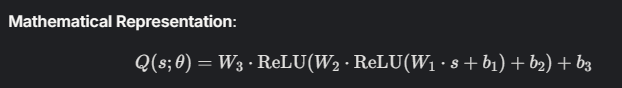

In [4]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.array(state), np.array(action), np.array(reward, dtype=np.float32), np.array(next_state), np.array(done, dtype=np.uint8)

    def __len__(self):
        return len(self.buffer)

ReplayBuffer

Purpose: Stores experience tuples 
(
𝑠
,
𝑎
,
𝑟
,
𝑠
′
,
𝑑
)
(s,a,r,s 
′
 ,d) for experience replay, a key DQN innovation to decorrelate training samples and improve stability.

Structure:

deque(maxlen=capacity): A double-ended queue with a fixed size (e.g., 100,000). When full, it discards the oldest transition to make room for new ones.

Methods:

push: Adds a transition tuple to the buffer. Each tuple contains:

state: Current state.

action: Action taken.

reward: Immediate reward.

next_state: Resulting state.

done: Boolean (1 if terminal, 0 otherwise).

sample: Randomly samples batch_size transitions:

zip(*...): Unpacks the list of tuples into separate lists.

random.sample: Ensures uniform sampling, breaking temporal correlation.

Returns NumPy arrays with appropriate dtypes (e.g., float32 for reward, uint8 for done) for efficient tensor conversion later.
__len__: Returns the current number of stored transitions.

In [7]:

class DQNAgent:
    def __init__(self, state_dim, action_dim, learning_rate, gamma, buffer_capacity, batch_size, target_update_freq, device="cpu"):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.buffer = ReplayBuffer(buffer_capacity)
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq
        self.device = device

        self.q_network = QNetwork(state_dim, action_dim).to(self.device)
        self.target_network = QNetwork(state_dim, action_dim).to(self.device)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=self.learning_rate)

        self.update_target_network()
        self.train_step = 0

    def choose_action(self, state, epsilon):
        if random.random() < epsilon:
            return random.randrange(self.action_dim)  # Explore
        else:
            state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(self.device)
            with torch.no_grad():
                q_values = self.q_network(state)
                return torch.argmax(q_values).item()  # Exploit

    def store_transition(self, state, action, reward, next_state, done):
        self.buffer.push(state, action, reward, next_state, done)

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

    def learn(self):
        if len(self.buffer) < self.batch_size:
            return

        state, action, reward, next_state, done = self.buffer.sample(self.batch_size)

        state = torch.tensor(state, dtype=torch.float32).to(self.device)
        action = torch.tensor(action, dtype=torch.long).unsqueeze(1).to(self.device)
        reward = torch.tensor(reward, dtype=torch.float32).unsqueeze(1).to(self.device)
        next_state = torch.tensor(next_state, dtype=torch.float32).to(self.device)
        done = torch.tensor(done, dtype=torch.uint8).unsqueeze(1).to(self.device)

        q_values = self.q_network(state).gather(1, action)
        next_q_values = self.target_network(next_state).max(1)[0].unsqueeze(1)
        target_q_values = reward + self.gamma * next_q_values * (1 - done)

        loss = F.mse_loss(q_values, target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.train_step += 1
        if self.train_step % self.target_update_freq == 0:
            self.update_target_network()

Purpose: Implements an 
𝜖

ϵ-greedy policy for action selection.

Logic:

Exploration: With probability 
𝜖
ϵ, pick a random action (0 to action_dim-1).

Exploitation: Otherwise, use the Q-network:
torch.tensor(state).unsqueeze(0): Converts state to a tensor and adds a batch dimension (e.g., [4] → [1, 4]).

q_network(state): Computes Q-values for all actions.

torch.argmax(q_values): Selects the action with the highest Q-value.

.item(): Extracts the integer action index.

Theory: Balances exploration (trying new actions) and exploitation (using the learned policy). 
𝜖
ϵ typically decays over time (not shown here).

Purpose: Adds a transition to the replay buffer for later training.

Simple: Delegates to ReplayBuffer.push, ensuring experiences are stored for sampling.

Purpose: Synchronizes the target network with the Q-network’s current weights.

Why?: The target network provides stable Q-value targets during training, reducing oscillations. It’s updated periodically (controlled by target_update_freq).

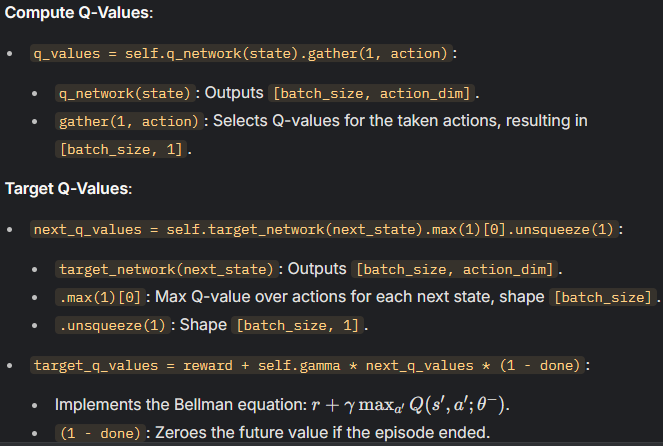

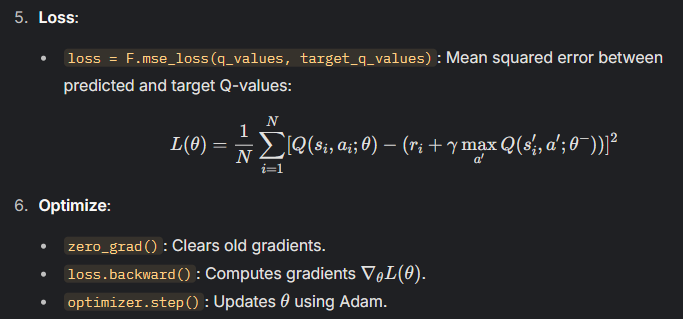

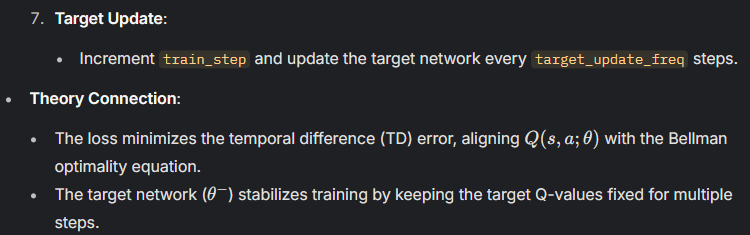

QNetwork: Learns 
𝑄
(
𝑠
,
𝑎
)
Q(s,a) to predict action values.

ReplayBuffer: Stores and samples experiences, enabling stable, batch-based learning.

DQNAgent: Manages exploration (
𝜖

ϵ-greedy), experience collection, and training:

Uses q_network for action selection and updates.

Uses target_network for stable Q-value targets.

Optimizes via gradient descent on the MSE loss.

In [ ]:
# Hyperparameters
learning_rate = 1e-3
gamma = 0.99
buffer_capacity = 10000
batch_size = 64
target_update_freq = 100
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay_steps = 500
num_episodes = 10
log_interval = 100
grid_size = 4

# Environment
env = GridWorldEnv(grid_size=grid_size)
state_dim = env.grid_size * env.grid_size  # One-hot encoded state
action_dim = env.n_actions

# Agent
agent = DQNAgent(state_dim, action_dim, learning_rate, gamma, buffer_capacity, batch_size, target_update_freq)

# Training loop
epsilon = epsilon_start
episode_rewards = []

for episode in range(num_episodes):
    state = env.reset()
    episode_reward = 0
    done = False

    while not done:
        action = agent.choose_action(state, epsilon)
        print("action",action)
        next_state, reward, done = env.step(action)
        print("next_state", next_state, "reward",reward, "done", done)
        agent.store_transition(state, action, reward, next_state, done)
        agent.learn()

        state = next_state
        print("state", state)
        episode_reward += reward
        print("episode_reward",episode_reward)

    episode_rewards.append(episode_reward)
    epsilon = max(epsilon_end, epsilon_start - (epsilon_start - epsilon_end) * episode / epsilon_decay_steps)
    print("epsilon", epsilon)

    if (episode + 1) % log_interval == 0:
        avg_reward = np.mean(episode_rewards[-log_interval:])
        print(f"Episode {episode + 1}, Average Reward: {avg_reward:.2f}, Epsilon: {epsilon:.2f}")
        env.render()

# env.close()

action 2
next_state [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] reward -0.1 done False
state [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
episode_reward -0.1
action 0
next_state [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] reward -0.1 done False
state [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
episode_reward -0.2
action 2
next_state [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] reward -0.1 done False
state [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
episode_reward -0.30000000000000004
action 1
next_state [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] reward -0.1 done False
state [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
episode_reward -0.4
action 3
next_state [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] reward -1 done True
state [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
episode_reward -1.4
epsilon 1.0
action 0
next_state [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] reward -0.1 done False
state [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

AttributeError: 'GridWorldEnv' object has no attribute 'close'

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import numpy as np
from collections import deque

class GridWorldEnv:
    def __init__(self, grid_size=4):
        self.grid_size = grid_size
        self.start_state = (0, 0)
        self.target_state = (grid_size - 1, grid_size - 1)
        self.obstacle_states = [(1, 1), (2, 2)]
        self.agent_pos = self.start_state
        self.action_space = [0, 1, 2, 3]  # Up, Down, Left, Right
        self.n_actions = len(self.action_space)
        self.reset()

    def reset(self):
        self.agent_pos = self.start_state
        return self._get_state()

    def _get_state(self):
        # Represent the state as a flattened 1D array (one-hot encoded agent position)
        state = np.zeros(self.grid_size * self.grid_size)
        row, col = self.agent_pos
        state[row * self.grid_size + col] = 1.0
        return state

    def step(self, action):
        row, col = self.agent_pos
        if action == 0:  # Up
            new_row = max(0, row - 1)
            new_col = col
        elif action == 1:  # Down
            new_row = min(self.grid_size - 1, row + 1)
            new_col = col
        elif action == 2:  # Left
            new_row = row
            new_col = max(0, col - 1)
        elif action == 3:  # Right
            new_row = row
            new_col = min(self.grid_size - 1, col + 1)

        self.agent_pos = (new_row, new_col)
        reward = -0.1  # Default step reward
        done = False

        if self.agent_pos == self.target_state:
            reward = 1
            done = True
        elif self.agent_pos in self.obstacle_states:
            reward = -1
            done = True

        return self._get_state(), reward, done

    def render(self):
        for r in range(self.grid_size):
            for c in range(self.grid_size):
                if (r, c) == self.agent_pos:
                    print("A", end=" ")
                elif (r, c) == self.start_state and (r, c) != self.agent_pos:
                    print("S", end=" ")
                elif (r, c) == self.target_state:
                    print("T", end=" ")
                elif (r, c) in self.obstacle_states:
                    print("#", end=" ")
                else:
                    print(".", end=" ")
            print()